# Recalibration of SMP density coefficients
*Josh King, Environment and Climate Change Canada, 2019*

The matched snow pit and SMP measurements from Part 1 are used to recalibrate the bilinear regression model of Proksch et al., (2015).


In [1]:
# Import community packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

import matplotlib.cm as cm
import pickle

from scipy import stats
from statsmodels.formula.api import ols
from sklearn.model_selection import KFold, StratifiedShuffleSplit

# Seed to replicate the paper result exactly
RANDOM_SEED = 2019

# Load comparison result from Part 1
result = pd.read_pickle('./output/smp_pit_filtered.pkl')
result['force_log'] = np.log(result['force_median'])

## K-Folds OLS method

OLS regression with 10 folds to minimize sampling bias.
Model coefficients and skill are evaluated as the mean of all folds.  

In [2]:
k_fold = KFold(10, True, RANDOM_SEED)
rmse = []
error = []
r = []
params = None

# Split the dataset into 10 roughly equal groups, 
# train on all but one test group
for train_idx, test_idx in k_fold.split(result):
    train = result.iloc[train_idx]
    test = result.iloc[test_idx]
    
    model_rho = ols("RHO ~ force_log + force_log * l + l", train).fit()
    predict_rho = model_rho.predict(exog=dict(force_log=test['force_log'], l=test['l']))
    rmse = np.append(rmse, np.sqrt(np.mean((predict_rho - test['RHO'])**2)))
    r = np.append(r,np.corrcoef(predict_rho, test['RHO'])[1][0])
    error = np.append(error, predict_rho - test['RHO'])
    
    if params is None:
        params = model_rho.params.values
    else:
        params =  np.vstack((params, model_rho.params.values))

In [3]:
# K19a evaluation stats (from k-folds method)
# Metrics presented as mean of all fold permutations

k19a_rmse = rmse.mean()
k19a_bias = error.mean()
k19a_r2 = r.mean()**2

print('K19a recalibration evaluation')
print('N: %i' % len(result))
print('RMSE: %0.1f' % k19a_rmse)
print('bias: %0.1f' % k19a_bias)
print('r^2: %0.2f' % k19a_r2)

K19a recalibration evaluation
N: 196
RMSE: 41.4
bias: 0.1
r^2: 0.72


In [4]:
model_k19a_coeff = [np.round(params[:,0].mean(),2), np.round(params[:,1].mean(),2),
              np.round(params[:,3].mean(),2), np.round(params[:,2].mean(),2)]
var_coeffs = [np.round(params[:,0].std(),2), np.round(params[:,1].std(),2),
              np.round(params[:,3].std(),2), np.round(params[:,2].std(),2)]

# Unbiased coeffs
print(model_k19a_coeff)

# Save coeffs
filename = './output/density_k19a_coeffs.pkl'
pickle.dump(model_k19a_coeff, open(filename, 'wb'))

[315.61, 46.94, -43.94, -88.15]


In [5]:
# Apply the new coeffs to estimate density
k19a_rho = model_k19a_coeff[0]+(model_k19a_coeff[1]*result['force_log'])+ \
           (model_k19a_coeff[2]*result['force_log']*result['l'])+ \
           model_k19a_coeff[3]*result['l']

## K-folds OLS with outliers removed

Outliers were defined as SMP/Cutter comparisons where error > than the 95th quantile in the K19a recalibration.  
We justify this in the paper in the context of the matching procedure which cannot be assumed to be perfect.  
Note that this removes a small number of comparisons which are not isolated to any one profile.

In [6]:
#Remove outliers
result_lim = result.copy()
result_lim['f_l'] = (result_lim['l'])*result_lim['force_log']
result_lim['abs_error'] = np.abs(k19a_rho - result_lim['RHO'])
q_95 = result_lim['abs_error'].quantile(0.95)
result_lim = result_lim[result_lim['abs_error'] < q_95]
n_removed  = len(result) - len(result_lim)

print('Error threshold: %i kg m^-3' % q_95)
print('Data points removed: %i' % n_removed)

Error threshold: 85 kg m^-3
Data points removed: 10


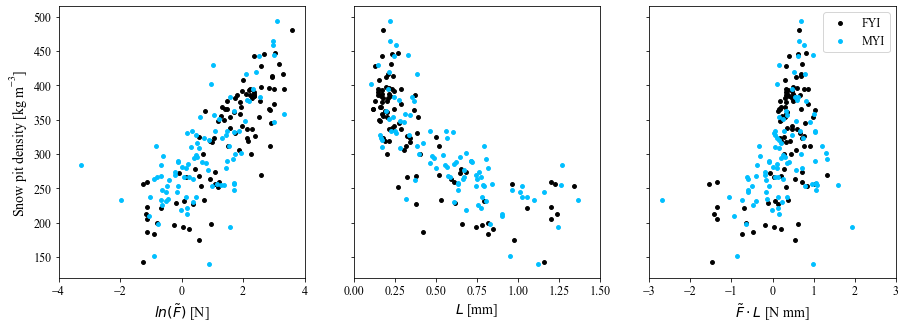

In [7]:
# Figure 5 from paper with caption
# 'Comparison of the SMP regression parameters and corresponding snow density observations. 
#  Parameters include log-transformed median force (ln(F ̃)), 
#  microstructure length scale (L) and an interaction term (f ̃L). 
#  Relationships are separated by ice surface environment.'

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))

axis_value_size = 12
axis_label_szie = 14
point_size = 15

ax1.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax2.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax3.tick_params(axis='both', which='major', labelsize=axis_value_size)

kws_myi = dict(color = 'deepskyblue', s = point_size)
kws_fyi = dict(color = 'black', s = point_size)

ax1.scatter(result_lim[result_lim['ice_type'] == 'f']['force_log'], 
            result_lim[result_lim['ice_type'] == 'f']['RHO'], 
            label='FYI', **kws_fyi)
ax1.scatter(result_lim[result_lim['ice_type'] == 'm']['force_log'], 
            result_lim[result_lim['ice_type'] == 'm']['RHO'], 
            label='MYI', **kws_myi)


ax2.scatter(result_lim[result_lim['ice_type'] == 'f']['l'], 
            result_lim[result_lim['ice_type'] == 'f']['RHO'], 
            label='FYI', **kws_fyi)
ax2.scatter(result_lim[result_lim['ice_type'] == 'm']['l'], 
            result_lim[result_lim['ice_type'] == 'm']['RHO'], 
            label='MYI', **kws_myi)

ax3.scatter(result_lim[result_lim['ice_type'] == 'f']['f_l'], 
            result_lim[result_lim['ice_type'] == 'f']['RHO'], 
            label='FYI', **kws_fyi)
ax3.scatter(result_lim[result_lim['ice_type'] == 'm']['f_l'], 
            result_lim[result_lim['ice_type'] == 'm']['RHO'], 
            label='MYI', **kws_myi)

ax1.set_ylabel('Snow pit density [kg m$\mathregular{^{-3}}$]', fontsize = axis_label_szie)
ax1.set_xlabel(r'$ln(\tilde{F})$ [N]', fontsize = axis_label_szie)
ax2.set_xlabel(r'$L$ [mm]', fontsize = axis_label_szie)
ax3.set_xlabel(r'$\tilde{F} \cdot L$ [N mm]', fontsize = axis_label_szie)

ax1.set_xlim(-4, 4)
ax2.set_xlim(0, 1.5)
ax3.set_xlim(-3, 3)

ax3.legend(fontsize = 12)

f.savefig('./output/figures/Fig5_RegressionTerms_LowRes.png', format='png')

In [8]:
# Correlation between snow pit observed density and median force, microstructural length scale and the interaction term
result_lim.groupby(['campaign','ice_type'])[['RHO','force_log','l','f_l']].corr()

RHO  force_log         l       f_l
campaign ice_type                                                   
a        m        RHO        1.000000   0.690954 -0.757093  0.236491
                  force_log  0.690954   1.000000 -0.658527  0.807845
                  l         -0.757093  -0.658527  1.000000 -0.370026
                  f_l        0.236491   0.807845 -0.370026  1.000000
e        f        RHO        1.000000   0.841431 -0.784002  0.527806
                  force_log  0.841431   1.000000 -0.763623  0.821215
                  l         -0.784002  -0.763623  1.000000 -0.594952
                  f_l        0.527806   0.821215 -0.594952  1.000000
         m        RHO        1.000000   0.461004 -0.843922  0.247466
                  force_log  0.461004   1.000000 -0.349396  0.922675
                  l         -0.843922  -0.349396  1.000000 -0.178584
                  f_l        0.247466   0.922675 -0.178584  1.000000

In [9]:
k_fold = KFold(10, True, RANDOM_SEED)
rmse = []
error = []
r = []
params = None

for train_idx, test_idx in k_fold.split(result_lim):
    train = result_lim.iloc[train_idx]
    test = result_lim.iloc[test_idx]
    
    model_rho = ols("RHO ~ force_log + force_log * l + l", train).fit()
    predict_rho = model_rho.predict(exog=dict(force_log=test['force_log'], l=test['l']))
    rmse = np.append(rmse, np.sqrt(np.mean((predict_rho - test['RHO'])**2)))
    r = np.append(r,np.corrcoef(predict_rho, test['RHO'])[1][0])
    error = np.append(error, predict_rho - test['RHO'])
    
    if params is None:
        params = model_rho.params.values
    else:
        params =  np.vstack((params, model_rho.params.values))


In [10]:
# K19a evaluation stats (from kfolds method)
k19b_rmse = rmse.mean()
k19b_bias = error.mean()
k19b_r2 = r.mean()**2

print('K19b recalibration evaluation')
print('N: %i' % len(result_lim))
print('RMSE: %0.1f' % k19b_rmse)
print('bias: %0.1f' % k19b_bias)
print('r^2: %0.2f' % k19b_r2)

K19b recalibration evaluation
N: 186
RMSE: 34.1
bias: -0.1
r^2: 0.78


In [11]:
model_k19b_coeff = [np.round(params[:,0].mean(),2), np.round(params[:,1].mean(),2),
              np.round(params[:,3].mean(),2), np.round(params[:,2].mean(),2)]
var_coeffs = [np.round(params[:,0].std(),2), np.round(params[:,1].std(),2),
              np.round(params[:,3].std(),2), np.round(params[:,2].std(),2)]

# Unbiased coeffs
print(model_k19b_coeff)

# Save coeffs
filename = './output/density_k19b_coeffs.pkl'
pickle.dump(model_k19b_coeff, open(filename, 'wb'))

[312.54, 50.27, -50.26, -85.38]


In [12]:
k19b_rho = model_k19b_coeff[0]+(model_k19b_coeff[1]*result_lim['force_log'])+ \
           (model_k19b_coeff[2]*result_lim['force_log']*result_lim['l'])+ \
           model_k19b_coeff[3]*result_lim['l']

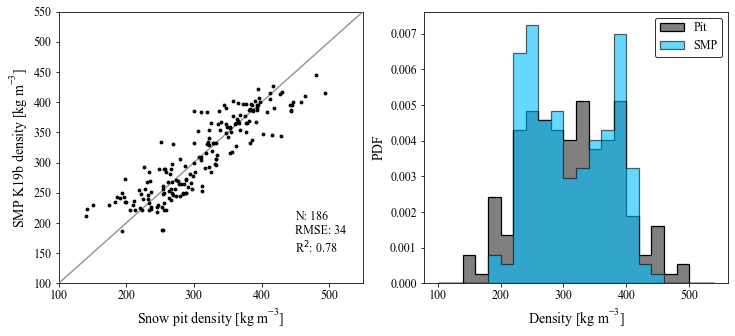

In [13]:
# Paper figure 4 (Bottom) with caption
# 'Evaluation of the SMP density model parametrization of Proksch et al. (2015) (P15; Top) 
#  and recalibrated coefficients for snow on sea ice (K19b; Bottom). 
#  In both cases the model is evaluated against manual density cutter measurements of snow density.'

axis_value_size = 12
axis_label_size = 14

line_start = 100
line_end = 550
point_size = 8

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax1.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax2.tick_params(axis='both', which='major', labelsize=axis_value_size)

ax1.scatter(result_lim['RHO'], k19b_rho, s = point_size, color ='black',  zorder = 1000)
ax1.plot([line_start, line_end], [line_start, line_end], 
         'k-', color = 'grey' ,alpha= 0.8,  zorder = 500)
ax1.set_xlim(line_start,line_end)
ax1.set_ylim(line_start,line_end)

rho_bin_size = 20 #in kg m-3
common_bin = np.arange(line_start,line_end, rho_bin_size)

hist_kws = dict(density=True, bins = common_bin, histtype= "stepfilled", linewidth = 1.25)
ax2.hist(result_lim['RHO'], alpha = 1, edgecolor="black", color = 'grey', label = 'Pit', **hist_kws)
ax2.hist(k19b_rho, alpha = 0.6, edgecolor="black", color = 'deepskyblue', label = 'SMP', **hist_kws)

ax1.text(450, 150,'N: %i \nRMSE: %i \nR$^2$: %0.2f'%(len(result_lim), k19b_rmse, k19b_r2),  fontsize=12)
ax1.set_ylabel('SMP K19b density [kg m$\mathregular{^{-3}}$]',fontsize=axis_label_size)
ax1.set_xlabel('Snow pit density [kg m$\mathregular{^{-3}}$]',fontsize=axis_label_size)
ax2.set_ylabel('PDF',fontsize=axis_label_size)
ax2.set_xlabel('Density [kg m$\mathregular{^{-3}}$]',fontsize=axis_label_size)
ax2.legend(edgecolor = 'black', fontsize=axis_value_size)

f.savefig('./output/figures/Fig4_K19Eval_LowQuality.png', format='png')

In [14]:
model_kfolds_coeff = [np.round(params[:,0].mean(),2), np.round(params[:,1].mean(),2),
              np.round(params[:,3].mean(),2), np.round(params[:,2].mean(),2)]
var_coeffs = [np.round(params[:,0].std(),2), np.round(params[:,1].std(),2),
              np.round(params[:,3].std(),2), np.round(params[:,2].std(),2)]

# Unbiased coeffs
print(model_kfolds_coeff)

# Save coeffs
filename = './output/density_k19b_coeffs.pkl'
pickle.dump(model_kfolds_coeff, open(filename, 'wb'))

[312.54, 50.27, -50.26, -85.38]


In [15]:
# Error metrics

def rmse(data):
    return np.sqrt(np.mean(data**2))

result_lim['model_rho'] = k19b_rho
result_lim['abs_error'] = np.abs(k19b_rho-result_lim['RHO']).values
result_lim['error'] = (k19b_rho-result_lim['RHO']).values

# Error by layer type
np.round(result_lim.groupby('TYPE')['error'].apply(rmse)/result_lim.groupby('TYPE')['model_rho'].mean(),3)

TYPE
F    0.086
H    0.140
R    0.107
dtype: float64

In [16]:
np.round(result_lim.groupby('campaign')['error'].apply(rmse)/result_lim.groupby('campaign')['model_rho'].mean(),3)

campaign
a    0.109
e    0.109
dtype: float64

In [17]:
# Overall error in %
np.round((rmse(result_lim['error'])/result_lim['model_rho'].mean()),3)

0.109